# Unsupervised Clustering of Board Game Reviews

_Ryan Harper_

In [1]:
import random
import numpy as np
from string import punctuation as punct
import matplotlib.pyplot as plt
import seaborn as sns
import os
import psutil
import operator
from math import ceil

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import v_measure_score
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec

from keras.layers import Dense, Input, CuDNNLSTM, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences

from IPython.display import display, Markdown, Latex

Using TensorFlow backend.


In [2]:
def beep(audio): 
    # for mac only: frog,blow,funk,glass,tink,submarine,purr,sosumi
    os.system('afplay /System/Library/Sounds/' + audio +'.aiff')
    
def memory_check():
    print('')
    print('CPU Percent: {} || Virtual Memory: {}'.format(psutil.cpu_percent(),psutil.virtual_memory()))
    print('')

# 1. Import and Clean Data

In [3]:
import pandas as pd

boardgamereviews = pd.read_csv('../data/boardgame/boardgame-comments-english.csv')
boardgamereviews.columns = 'reviewer_id', 'game_id', 'rating', 'comment'
unique_id = boardgamereviews.reviewer_id.unique()
sample_id = random.sample(unique_id.tolist(),2000)
review = boardgamereviews[boardgamereviews['reviewer_id'].isin(sample_id)]

#### _Ratings equal the difference between a user's rating and that user's average rating._

In [4]:
review['rating_normed']=review.rating - review['rating'].groupby(review['reviewer_id']).transform('mean')
review['rating_normed']=(review['rating_normed']-review['rating_normed'].min())/(review['rating_normed'].max()-review['rating_normed'].min())
review['rating_normed']=review['rating_normed'].apply(lambda val: val*10).apply(ceil)
if 0 not in review['rating'].unique():
    review['rating_normed']=review['rating_normed'].apply(lambda val: 1 if val==0 else val)
# review['estimate'] = review['rating_normed'] + review['rating'].groupby(review['reviewer_id']).transform('mean')

In [5]:
review['rating'] = review['rating'].apply(round)
memory_check()


CPU Percent: 28.8 || Virtual Memory: svmem(total=8589934592, available=2230583296, percent=74.0, used=6204309504, free=1033506816, active=3311587328, inactive=1197076480, wired=1695645696)



# 2. Visualize

#### _The ratings appear normalized after reviews are adjusted according to user specific ratings_

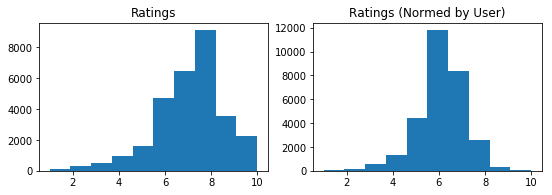

In [6]:
plt.figure(figsize=(9,6))
plt.subplot(2,2,1)
plt.hist(review.rating,bins=10)
plt.title('Ratings')

plt.subplot(2,2,2)
plt.hist(review.rating_normed,bins=10)
plt.title('Ratings (Normed by User)');

# 3. Tokenize

In [7]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)

# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments

comments_train = list(review["comment"].fillna("NAN_WORD").values)
review['token'] = process_comments(comments_train, lower=True)

Processing text dataset


100%|██████████| 29654/29654 [00:01<00:00, 26820.25it/s]


In [8]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))
print('')
memory_check()

The vocabulary contains 23738 unique tokens


CPU Percent: 38.1 || Virtual Memory: svmem(total=8589934592, available=2112798720, percent=75.4, used=6322520064, free=915726336, active=3453177856, inactive=1197072384, wired=1672269824)



# 4. Vocab Scoring Model

_CREDIT: Methodology and some code for this section closely follows Kenny Liao's Approach_

#### Vocab Rating Baseline

#### Naive Set Median

# 5. Vectorize

In [9]:
from gensim.models import Word2Vec

In [10]:
WV_DIM = 200
model = Word2Vec(review['token'], size=WV_DIM, window=10, min_count=1, workers=4, sg=0, negative=3)
vec_size = model.layer1_size
word_vectors = model.wv

In [11]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 23738


__Cosine Similarity Function__

$$ cos(\theta) = \frac{A \bullet B} {\Vert A \Vert \Vert B \Vert} =  \frac{\sum_{i=1}^n A_i B_i}{\sqrt{ \sum_{i=1}^n A^2} \sqrt{ \sum_{i=1}^n B^2}} $$

_Version A. Raw Code_

#### _Used the cosine similarity function to check common words. 'Easy' and 'Simple' appear to be much more similar than 'Cat'.<br> <br>A good sign that the vectorization worked!_

### Word2Vec Visualization

/NOT FINISHED/

# 6. Word Embedding

In [12]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = min(50,int(review.comment.apply(len).median()))

In [13]:
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

In [14]:
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in review['token']]

In [15]:
# pad
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
y = pd.get_dummies(review['rating']).values

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (29654, 50)
Shape of label tensor: (29654, 10)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [17]:
target_categorical_unique = len(review['rating'].unique())

In [18]:
# NOTE: This code was from a tutorial and seems to be accounting for an error I can't find but in doing so creates a new error
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
# NOTE: changed to nb_words+1 to account for index error, not sure why it broke in the first place
wv_matrix = (np.random.rand(nb_words+1, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        embedding_vector = word_vectors[word]
        wv_matrix[i] = embedding_vector
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        continue   

In [19]:
memory_check()


CPU Percent: 74.7 || Virtual Memory: svmem(total=8589934592, available=2032205824, percent=76.3, used=6402326528, free=835121152, active=3571748864, inactive=1197084672, wired=1633492992)



# 5. Models

In [20]:
from keras import backend
 
def rmse(y_true, y_pred):
    print(y_true[0])
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

$$ RMSE_{y} =  \sqrt{\frac{\sum_{i=1}^n {(\hat{y}_{i}- y_{i})}^2}{N}} $$

In [21]:
K.clear_session()

wv_layer = Embedding(nb_words+1,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)
# biGRU
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)
# Output
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
preds = Dense(target_categorical_unique, activation='sigmoid')(x)

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='mae',
              optimizer='sgd',
              metrics=[rmse])

model.summary()

Tensor("metrics/rmse/strided_slice:0", shape=(?,), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 200)           4747800   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               135680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (D

In [22]:
from keras.callbacks import Callback, EarlyStopping
import resource

In [23]:
class MemoryCallback(Callback):
    def on_epoch_end(self, epoch, log={}):
        memory_check()
        
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto')

In [ ]:
hist = model.fit(X_train, y_train, validation_split=0.33,batch_size=128,
                 epochs=100, verbose=1,callbacks=[])

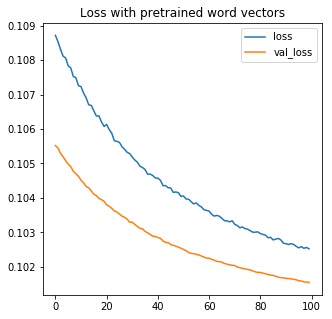

In [41]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(5,5));
plt.plot(history["loss"]);
# validation loss
plt.plot(history["val_loss"]);
plt.title("Loss with pretrained word vectors")
plt.legend()
plt.show();

In [42]:
score = model.evaluate(X_test, y_test, verbose=0)

In [43]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10157423343837935
Test accuracy: 0.3151141133211532


In [44]:
predict = model.predict(X_test)

In [45]:
def convert_to_one(p):
    new_p =[]
    for values in p:
        l = []
        max_index,_ = max(enumerate(values), key=operator.itemgetter(1))

        for m in range(len(values)):
            if m!=max_index:
                l.append(0)
            else:
                l.append(1)
        new_p.append(l)
        
    return new_p

In [46]:
from keras.backend import argmax as kargmax
y_predict = np.argmax(predict,axis=1)
y_actual = np.argmax(y_test,axis=1)

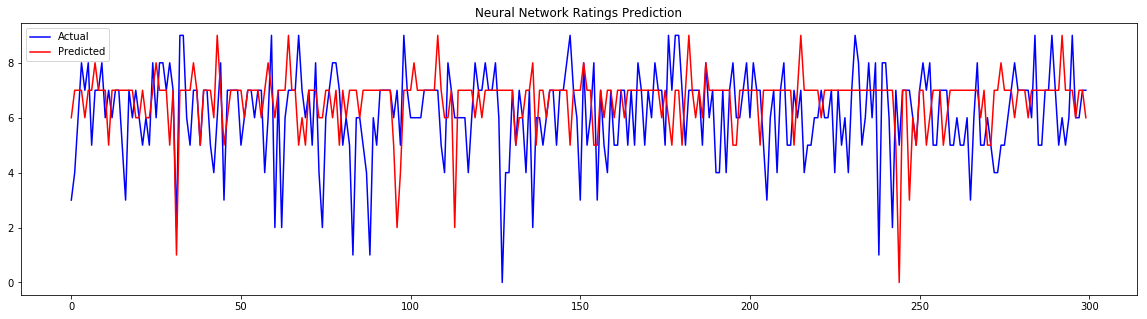

In [63]:
plt.figure(figsize=(20,5))
plt.plot(y_actual[0:300],color='b')
plt.plot(y_predict[0:300],color='r')
plt.title('Neural Network Ratings Prediction')
plt.legend(['Actual','Predicted'])
plt.show()

In [58]:
# John's Confusion Matrix Function
from sklearn.metrics import confusion_matrix

def plot_confusion(y, y_pred, title):
    # rating levels
    ratings = list(range(1,11))

    # generate confusion matrix
    cm = confusion_matrix(y, y_pred)

    # normalize matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # plot matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.magma)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(ratings))
    plt.xticks(tick_marks, ratings, rotation=45)
    plt.yticks(tick_marks, ratings)
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('Actual rating')
    plt.xlabel('Predicted rating');

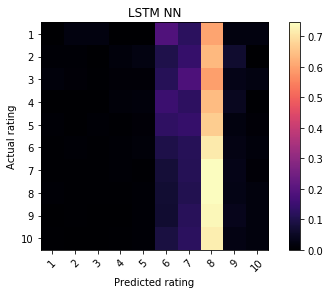

In [59]:
plot_confusion(y_actual,y_predict,'LSTM NN')

## _Root Mean Squared Error_

In [50]:
RMSE = np.sqrt(np.sum(np.square(np.subtract(y_predict,y_actual)))/len(y_actual))

In [51]:
print(RMSE)

1.936480789626415


# 8. Test Predictions

In [78]:
boardgametest = pd.read_csv('../data/boardgame/boardgame-comments-english-test.csv')
# boardgametest.columns = ['revid','gameid','comment']
comments_train = list(boardgametest["comment "].fillna("NAN_WORD").values)
boardgametest['token'] = process_comments(comments_train, lower=True)
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in boardgametest['token'] ]

100%|██████████| 2598/2598 [00:00<00:00, 21686.52it/s]


In [79]:
X_final = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

print('Shape of data tensor:', X_final.shape)

Shape of data tensor: (2598, 50)


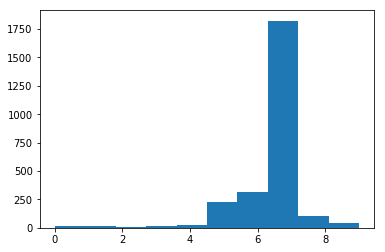

In [80]:
final_predict = model.predict(X_final)
final_predict = np.argmax(final_predict,axis=1)
plt.hist(final_predict);

In [81]:
boardgametest['predict'] = final_predict
del boardgametest['comment ']
del boardgametest['token']
boardgametest.to_csv('ryan_lstm_predict2.csv')